# Credit Card Customer Segmentation With K-Means Clustering

## Introduction
---
A credit card company has a portfolio of clients that wishes to profile to better develop effective marketing and business strategies. To achieve this goal we're going to resort to the K-means clustering technique to define and characterize different types of client profiles, and suggest some business strategies according to those findings.  





Data Description:

| Column                          | Description                                                                 |
| --------------------------------|-----------------------------------------------------------------------------|
| `customer_id`              | Unique identifier for each customer.                                             |
| `age`                      | Customer age in years.                                                           |
| `gender`                   | Customer gender (M or F).                                                        |
| `dependent_count`          | Number of dependents of each customer.                                           |
| `education_level`          | Level of education ("High School", "Graduate", etc.).                            |
| `marital_status`           | Marital status ("Single", "Married", etc.).                                      |
| `estimated_income`         | The estimated income for the customer projected by the data science team.        |
| `months_on_book`           | Time as a customer in months.                                                    |
| `total_relationship_count` | Number of times the customer contacted the company.                              |
| `months_inactive_12_mon`   | Number of months the customer did not use the credit card in the last 12 months. |
| `credit_limit`             | Customer's credit limit.                                                         |
| `total_trans_amount`       | The overall amount of money spent on the card by the customer.                   |
| `total_trans_count`        | The overall number of times the customer used the card.                          |
| `avg_utilization_ratio`    | Daily average utilization ratio.                                                 |

## Exploratory Data Analysis

---

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
origin = pd.read_csv('customer_segmentation.csv')

origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

The data set has no missing values but has some variables that are not very helpful in profiling the client for our purpose, and can be dropped:
- `customer_id`, we are not interested in identifying each customer.


- `total_relationship_count`, the number of times a customer reaches out to the company is not very insightful compared with the other features, unless we are distinguishing each costumer's contact by type: information request, complaint, service alteration, service adhesion, etc. Unfortunately, we don't have that information so we drop this column.

Next, we convert `object` type columns into category types; keep the `original` data set for later use and continue the data wrangling with `cust`.

In [3]:
origin = origin.drop(
    columns=['customer_id', 'total_relationship_count']
    )

for col in origin.columns:
    if origin[col].dtype == object:
        origin[col] = pd.Categorical(origin[col])

cust = origin.copy()

There are three categorical variables: `gender` and `marital_status` can be converted into dummies, while `education_level` can be converted into an ordinal scale since each category represents a level of education. We can map it in the following way:
- `1` if 'Uneducated' 
- `2` if 'High School' 
- `3` if 'College' 
- `4` if 'Graduate' 
- `5` if 'Post-Graduate' 
- `6` if 'Doctorate' 

In [4]:
dict_edu = {
    'Uneducated': 1,
    'High School': 2,
    'College': 3,
    'Graduate': 4,
    'Post-Graduate': 5,
    'Doctorate': 6,
    }

cust['education_level_num'] = cust.education_level.map(dict_edu)

cust = cust.drop(columns='education_level')


cust = pd.get_dummies(
    data=cust,
    columns=['gender'],
    drop_first=True
    )

cust = pd.get_dummies(
    data=cust,
    columns=['marital_status'],
    drop_first=False
    )


Given the changes made so far in `cust` we have:

In [5]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      10127 non-null  int64   
 1   dependent_count          10127 non-null  int64   
 2   estimated_income         10127 non-null  int64   
 3   months_on_book           10127 non-null  int64   
 4   months_inactive_12_mon   10127 non-null  int64   
 5   credit_limit             10127 non-null  float64 
 6   total_trans_amount       10127 non-null  int64   
 7   total_trans_count        10127 non-null  int64   
 8   avg_utilization_ratio    10127 non-null  float64 
 9   education_level_num      10127 non-null  category
 10  gender_M                 10127 non-null  uint8   
 11  marital_status_Divorced  10127 non-null  uint8   
 12  marital_status_Married   10127 non-null  uint8   
 13  marital_status_Single    10127 non-null  uint8   
 14  marita

### Correlation heat map.

The heat correlation map helps us find strong correlations between variables. A very high correlation between two variables may indicate that using both in a K-means clustering process may not be ideal since if both (standardized) variables show similar distances over the centroids then one of them is irrelevant for the calculation of overall distances. On the other hand, despite of a high correlation, keeping both variables can help to characterize each cluster, despite of the similar behavior.

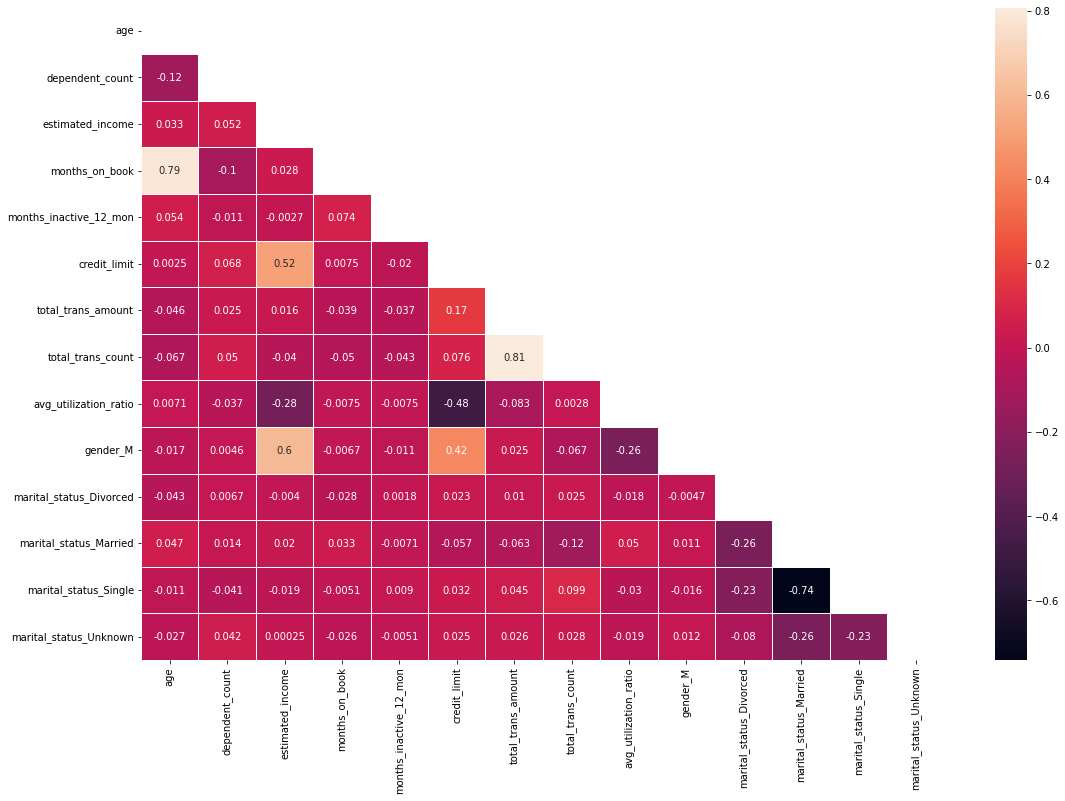

In [6]:
features = cust.columns

corr = cust[features].corr(method='pearson')

# Draw a heatmap with the numeric values in each cell.
f, ax = plt.subplots(figsize=(18, 12))

# Getting the Upper Triangle of the co-relation matrix.
matrix = np.triu(corr)

sns.heatmap(corr,
            annot=True,
            linewidths=.5,
            mask=matrix,
            ax=ax)

plt.show()

As we can, see there are a few cases of strong correlation, say over 50%:

- `months_on_book` with `age` (79%): in this case it is expected that the older the client is the more loyal she/he is. 


- `tot_trans_count` with `tot_trans_amount` (81%): this strong correlation tells us that clients that use the credit card more often are also spending more, as oppose to having clients that use the card sparsely but spend substantial amounts.


- `marital_status_Single` with `marital_status_Married` (-74%): this is expected since these variables are inversely correlated with each other, because they are dummies derived from the same categorical variable.


- `credit_limit` with `estimated_income`(0.52%): this correlation is somewhat expected since, usually, the higher the earnings the higher is the credit ceiling.


- `gender_M` with `estimated_income` (60%): this can be caused by a majority of male clients with high incomes. Let's check the distribution of values by gender over the mean estimated income. Given the values below, 89% of the clients with incomes over the mean are male.

In [20]:
mean_income = cust.estimated_income.mean().round(2)

pct_over_mean_income = cust.query('estimated_income > @mean_income').gender_M.value_counts(normalize=True)[1].round(2)*100

print(f'Mean income (both genders): {mean_income}')
print(f'Percentage of man clients over the mean income: {pct_over_mean_income}')

Mean income (both genders): 62078.21
Percentage of man clients over the mean income: 89.0


### Histogram analysis

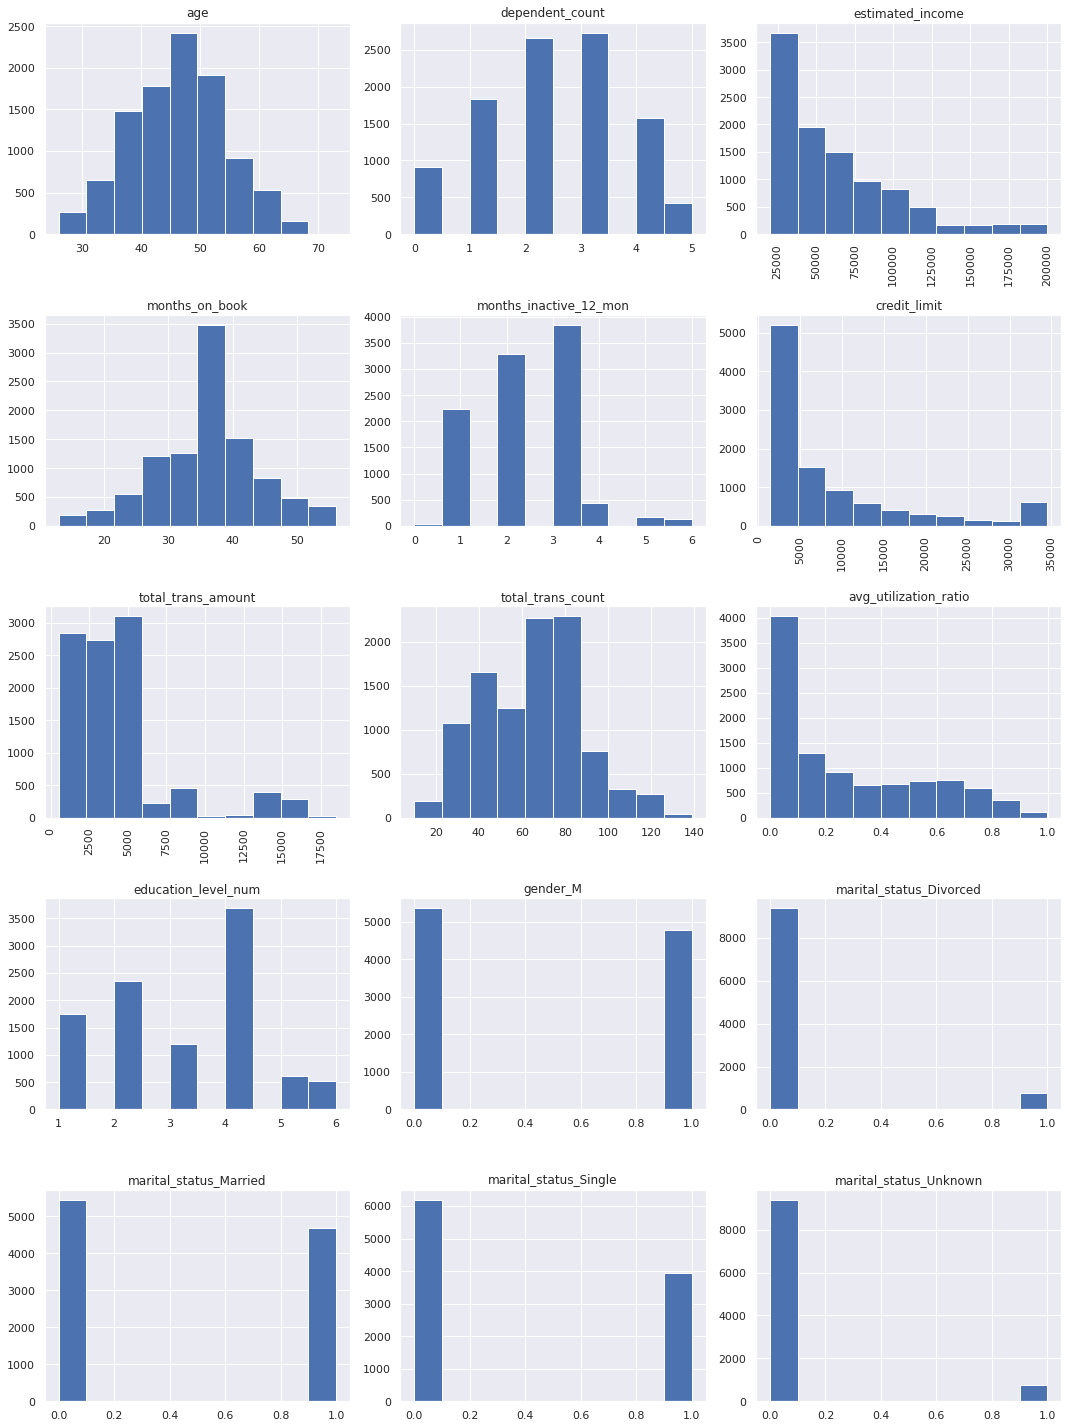

In [19]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

sns.set_theme()

for i in range(0, cust.columns.size):
    if i < 3:
        ax_ = ax[0, i]        
    elif 3 <= i < 6:
        ax_ = ax[1, i-3]
    elif 6 <= i < 9:
        ax_ = ax[2, i-6]
    elif 9 <= i < 12:
        ax_ = ax[3, i-9]
    elif 12 <= i:
        ax_ = ax[4, i-12]        

        
    ax_.hist(cust[features[i]], align='mid')
    ax_.set_title(features[i])
    ax_.grid(zorder=-1)
    if features[i] in [
        'estimated_income', 'credit_limit', 'total_trans_amount'
        ]:
        ax_.tick_params(axis='x', labelrotation = 90)
        
        
plt.tight_layout()        
plt.show()

- `age`: is normally distributed with the majority of people being around 50 years old.
- `dependent_count`: the majority of clients has dependents, being more common 2 to 3 individuals.
- `estimated_income`: the majority of clients earns below 50K, and the number of clients with a higher income decreases as the income echelon increases.
- `months_on_book`: most clients have been with the company for 35 months (around 3 years).
- `months_inactive_12_mon`: most clients haven't use the credit card from 1 up to 3 months.
- `credit_limit`: most credit is up to 5K, sharply decreasing after that.
- `total_trans_amount`: the majority of the total value of transactions is up to 5K.
- `total_trans_count`: the number of transactions made by clients is dispersed over a large interval from 20 up to 90 transactions but more frequent between the 60 to 80 interval.
- `avg_utilization_ratio`: most clients have a daily use ratio below 10%.
- `education_level_num`: the most represented level of education is graduate or college level, followed by high school level or less.
- `gender_M`: gender is evenly distributed with slightly more women.
- `marital_status`: married is the most represented status (46.28%), followed by single (38.94%), and to a lesser extent unknown and divorced (~7.4 each).


### Scaling the data.

Scaling the data helps to standardize the weight each variables has when calculating the distances to the centroids.

In [10]:
scaler = StandardScaler()


cust_scaled = pd.DataFrame(
    scaler.fit_transform(cust),
    columns=cust.columns
    )

## K-means Cluster Analysis
---
### Choosing  a number of clusters based on inertia levels and the elbow rule.

First, lets calculate different scenarios for up to 10 clusters and visually observe their levels of inertia. The objective is to find the number of clusters that produces a level of inertia that is not substantially reduced when we attempt to include another cluster to the process.

We'll be using a fixed random state to define the initial centroids - `776`, to assure the ability to repeat the results if required. We summarize the findings in the graph below.

In [11]:
inertia_list = []

for i in range(1, 10+1):
    kmeans = KMeans(i, random_state=776)
    model = kmeans.fit_predict(cust_scaled)
    inertia_list.append(round(kmeans.inertia_, 2))

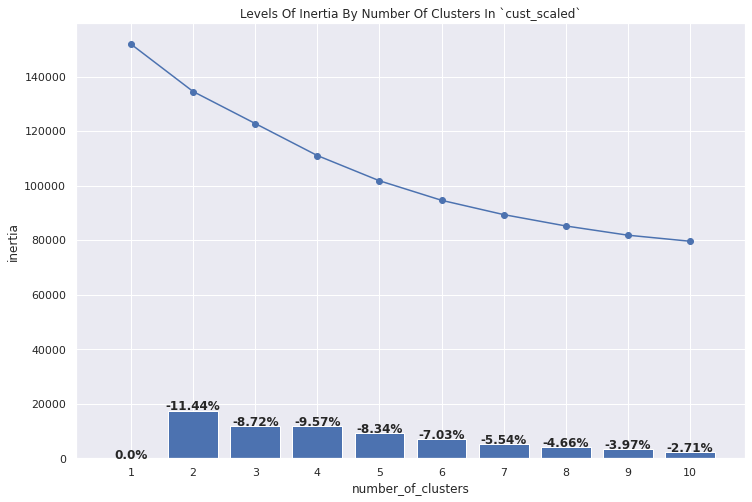

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

inertia_diff = pd.Series(inertia_list, name='inertia').diff().abs()
inertia_diff[0] = 0
inertia_pct_change = pd.Series(inertia_list, name='inertia').pct_change()*100
inertia_pct_change = inertia_pct_change.round(2)
inertia_pct_change[0] = 0

ax.plot(np.arange(1, 10+1, 1), inertia_list, marker='o')

bar_plot = ax.bar(np.arange(1, 10+1, 1), inertia_diff)

i = 0
for bar in bar_plot:
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    plt.text(round(x+width/2, 0),
             round(y+height*1.02, 0),
             f'{inertia_pct_change[i]}%',
             ha='center',
             weight='bold')
    i += 1



plt.xticks(np.arange(1, 10+1, 1))
plt.title('Levels Of Inertia By Number Of Clusters In `cust_scaled`')
plt.xlabel('number_of_clusters')
plt.ylabel('inertia')
plt.grid(zorder=-1)
plt.show()

The graph above provides us two different information elements: the line shows the behavior of the inertia level as the number of clusters increase, while the horizontal bars show the difference in absolute terms between the current and the prior cluster/inertia value; the values above the bars are the analogous percentage changes. 

As we can see, there is no accentuated drop in the level of inertia as the number of cluster increases, therefore, the decision to choose a number of cluster becomes less evident. In order to choose a number of clusters we can create a criterion that is still based on the inertia's behavior: given that we have 10 inertia values how many clusters do we need so that the percentage drop in the inertia value for one cluster to that number of clusters is at least the double of the percentage drop in inertia from that number of clusters to ten clusters? The loop below calculates those percentages changes and answers the question.

In [13]:
for i in range(1, 10+1):
    mid_clust = inertia_list[i-1]
    one = inertia_list[0]
    ten = inertia_list[9]
    change_one_mid = round(abs(one-mid_clust)*100/one, 2)
    change_mid_ten = round(abs(mid_clust-ten)*100/mid_clust, 2)
    print(f'For {i} cluster:')
    print(f'Inertia change cluster 1 to {i}: {change_one_mid}%')
    print(f'Inertia change cluster {i} to 10: {change_mid_ten}%')
    
    condition_double = change_one_mid > change_mid_ten*2
    
    print(f'Is the inertia change from cluster 1 to {i} at least the double of the inertia change from cluster {i} to 10: {condition_double}.\n')
    

For 1 cluster:
Inertia change cluster 1 to 1: 0.0%
Inertia change cluster 1 to 10: 47.59%
Is the inertia change from cluster 1 to 1 at least the double of the inertia change from cluster 1 to 10: False.

For 2 cluster:
Inertia change cluster 1 to 2: 11.44%
Inertia change cluster 2 to 10: 40.82%
Is the inertia change from cluster 1 to 2 at least the double of the inertia change from cluster 2 to 10: False.

For 3 cluster:
Inertia change cluster 1 to 3: 19.17%
Inertia change cluster 3 to 10: 35.17%
Is the inertia change from cluster 1 to 3 at least the double of the inertia change from cluster 3 to 10: False.

For 4 cluster:
Inertia change cluster 1 to 4: 26.9%
Inertia change cluster 4 to 10: 28.31%
Is the inertia change from cluster 1 to 4 at least the double of the inertia change from cluster 4 to 10: False.

For 5 cluster:
Inertia change cluster 1 to 5: 32.99%
Inertia change cluster 5 to 10: 21.79%
Is the inertia change from cluster 1 to 5 at least the double of the inertia change fro

As we can see, when we arrive at the inertia value for 6 clusters the percentage drop from 1 to 6 clusters is, for the first time, more than the double of the inertia percentage drop from 6 to 10 clusters (the analogous drop is more than the triple for 7 clusters). Because increasing the number of clusters from this point decreases less and less the inertia value, we opt to proceed the analysis with 6 clusters.

### Analysis for a six-cluster partition of the data. 

In [14]:
kmeans = KMeans(6, random_state=776)

clusters_array = kmeans.fit_predict(cust_scaled)

origin['cluster'] = clusters_array


numerical = []
categorical = []

for col in origin.columns[:-1]:
    if isinstance(origin[col].dtype, pd.CategoricalDtype):
        categorical.append(col)
    else:
        numerical.append(col)

#### Analysis of numerical variables per cluster.

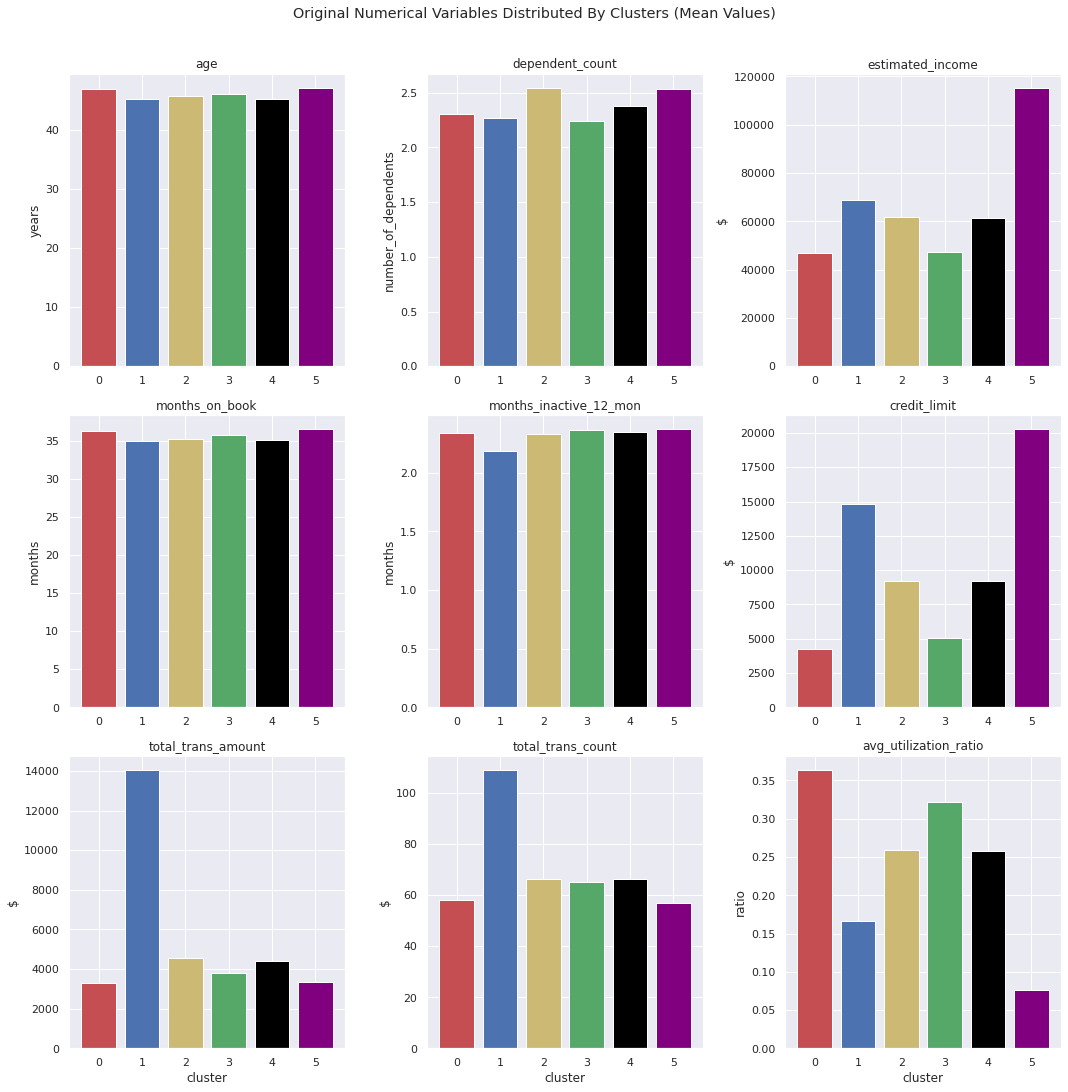

In [15]:
y_labels = [
    'years',
    'number_of_dependents',
    '$',
    'months',
    'months',
    '$', 
    '$', 
    '$',
    'ratio'
    ]

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

plt.suptitle('Original Numerical Variables Distributed By Clusters (Mean Values)', y=1.01)

colors = ['r', 'b', 'y', 'g', 'black', 'purple']

def color_bars(ax):
    for patch,color in zip(ax.patches,colors):
        patch.set_facecolor(color)
    return

for i, col in enumerate(numerical):
    
    grouped_cluster = origin.groupby(by='cluster')[col].mean()

    if i < 3:
        ax_ = ax[0, i]        
    elif 3 <= i < 6:
        ax_ = ax[1, i-3]
    elif 6 <= i < 9:
        ax_ = ax[2, i-6]
        ax_.set_xlabel('cluster')
        
    ax_.bar(grouped_cluster.index, grouped_cluster)
    color_bars(ax_)
    ax_.set_title(col)
    ax_.set_ylabel(y_labels[i])
        
        
plt.tight_layout()        
plt.grid(zorder=-1)
plt.show()

The bar chart grid above reveals us that the clusters are not very distinguishable by age, client seniority, number of dependents or card inactivity. In both cases, the average client is over 40 years old, has at least two dependents, is client for more than 35 months (around 3 years), and hasn't used the card for the past 2 months or more. We can also add that the behavior of the `credit_limit` is similar to the `estimated_income`, since the natural logic is that the credit limit grows as income grows. Regarding the other features:


- clients in cluster `0` have the highest average daily utilization (>0.35); their total spending is on par with all other clusters (>3K) to the exception of cluster `1`, although on the lower side. Their estimated income is the lowest (<50k) along with clients in cluster `3`.


- clients in cluster `1` are by far the group that spent the most - around 14K, and at the same time show the highest number of transactions - over 100 (as we saw earlier these variables are highly correlated). This group has the second highest income - over 60K and credit limit - 15K. Despite of having the highest number of transactions the average daily use is the second lowest.


- clients in cluster `5` have the highest income and credit limit by far - over 110K, and around 20K respectively; on the other hand, their total spending and card usage is on par with the majority of the other clusters, with an exceptionally low daily usage.


#### Scatter plot analysis of income vs daily usage.

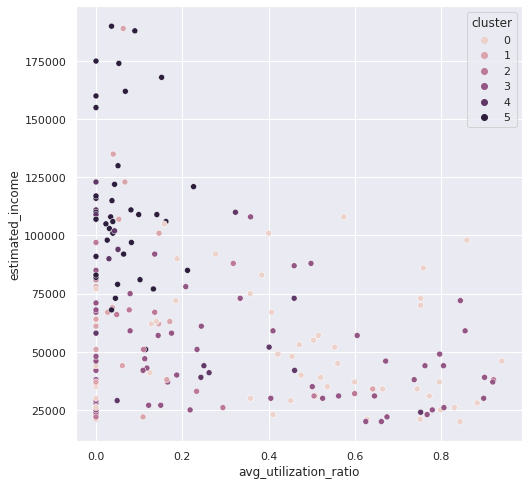

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(
    data=origin.sample(n=200, random_state=123),
    x='avg_utilization_ratio',
    y='estimated_income',
    hue='cluster'
    )

plt.show()

In the scatter plot above is portrayed a sample of 200 observations from the original data set, distributed by the 6 clusters (`0` to `5`); we can see that clusters `0` and `3` have low income and high daily card usage, while cluster `5` has high income and low daily usage.

#### Distribution of categorical variables by cluster.

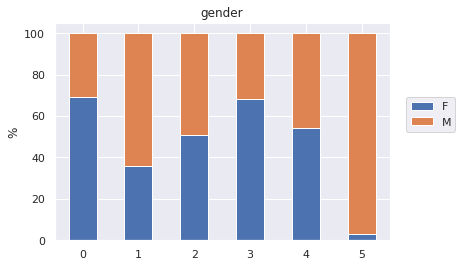

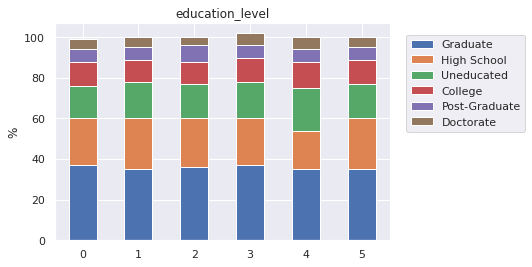

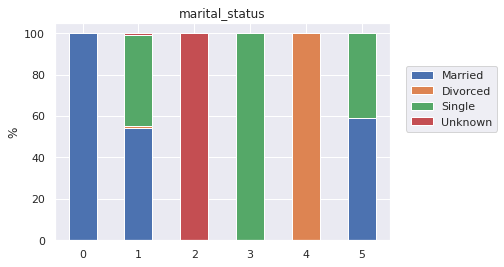

In [17]:
categorical_dfs = []

for i, col in enumerate(categorical):
    cluster_dist = origin.groupby(by='cluster')[col].value_counts(normalize=True).round(2)*100

    df = pd.DataFrame(
        {
            i: cluster_dist[i] for i in range(0, 5+1)
        },
        index=list(cluster_dist[0].index)
        )

    df = df.transpose()

    categorical_dfs.append(df)

for i, df in enumerate(categorical_dfs):
    df.plot(kind = 'bar', stacked = True, title=categorical[i], rot=0)
    plt.ylabel('%')
    plt.legend(df.columns, loc=(1.05, 0.5))
    plt.show()

In the cluster analysis we've seen that the most interesting cluster were the `0`, `1` and `5`. What can we add to their characterization when looking into the distribution of categorical variables by cluster? To start with, we can see that the education level is almost identical for every cluster, making it irrelevant for the analysis. Regarding the formers cluster, we have:

- cluster `0` is composed of almost 70% female clients while virtually entirely composed of married clients.


- cluster `1` is the most homogeneous, where more than 60% are male clients and the marital status its well divided between single and married. 


- cluster `5` is above 95% male while being composed of around 60% married clients, while the rest are single.


- cluster `3` is composed entirely of single clients, while cluster `4` is composed entirely of `divorced` clients.

## Summarizing The Findings And Suggesting  Business Strategies
---

|Cluster                    |Characterization               |
|---------------------------|-------------------------------|
|`0`                        |Low income, highest daily use, predominately married, predominantly women.|
|`1`                        |Highest spenders, high total transactions, medium-high income, medium-low daily use, mixed marital status.|
|`2`                        |Medium income, high daily use.|
|`3`                        |Low income, 2nd highest daily use, predominantly single.|
|`4`                        |Medium income, medium-high daily use, predominantly divorced.|
|`5`                        |Highest income, low spending, lowest daily use, mixed marital status, predominantly men.|



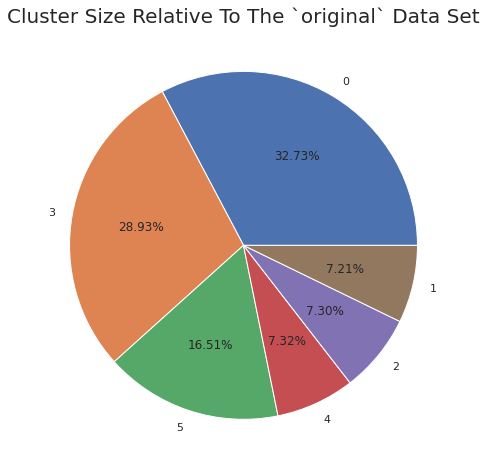

In [24]:
fig, ax = plt.subplots(figsize=(8,8))

plt.title('Cluster Size Relative To The `original` Data Set', size=20)

cluster_counts = origin.cluster.value_counts()

ax.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.2f%%')

plt.show()

By crossing the information in the previous cluster characterization table and the pie chart we can see that there are two broader groups of clusters that oppose each other: in one side there are the clusters `0` and `3` which account for a little over 60% of the clients and are characterized by high daily use and low income; on the other group we have clients with medium to high income, where clients in cluster `1` are high spenders (~7%) while clients in cluster `5` are low spenders (16.5%). Given this landscape we can propose two different strategy paths:   



Strategies to increase costumers' card usage:

- Directed towards clusters `0`, `2`, `3`, and `4`: 
	- Drop in the minimum payment fee per utilization in about a substantial portion, e.g. 30 to 50%, after a certain number of daily, weekly or monthly uses; based on the client's expected number of transactions for that period.  


- Directed towards cluster `0`:
	- Flexibilize card payments for expenditures made in certain retail stores predominantly visited by families (specially married woman with children).
	- Eliminate balance transfer fee between couples (if both are clients) in the first 5 days of each month.


Strategies to increase costumers' high expenditures: 

- Directed towards cluster `5`: 
	- Run temporary campaigns with a substantial drop (e.g. 50%) in the interest rate for expenditures over a certain amount.  



- Directed towards cluster `1`, `2`, `4` and `5`: 
	- Eliminate foreign transaction fees for expenditures over a certain amount (when traveling outside of the country).
    
\[End of Project\]